In [1]:
pip install opencv-python==4.5.5.64 --user

     |████████████████████████████████| 60.5 MB 17 kB/s s eta 0:00:01    |███████████                     | 20.7 MB 867 kB/s eta 0:00:46
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import torch 
import torch.nn as nn
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage.measure
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from tqdm import tqdm

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-zu4luy5n because the default path (/home/ubuntu/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/opt/conda/lib/python3.8/site-packages/scipy/__init__.py:138: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3)
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion} is required for this version of "


## What are Convolutional Neural Nets?

CNNs are a family of models that are inspired by how humans classify images, which is by recognizing specific features or patterns anywhere in the image that distinguish each particular object class. <br />
A CNN classifies images as follows: 
> Identify low-level features in the input image (edges, blobs of color, etc.) <br />
> These low-level features are then combined to form high-level features (parts of ear, eyes, etc) <br />
> The presence or absence of these high-level features contributes to the probability of any given output class. 

Where you find CNN in your day-to-day...
- <b>Surveillance systems</b> detecting faces within images reducing distortions from image aspects like angles or shadows on faces
- <b>Digitalization of documents</b> where CNN take image of handwritten documents to identify characters in different languages
- <b>Medical imaging</b> to identify tumors, fractures or other abnormalities in X-ray images
- <b>Biometric authentication like FaceID</b> where CNN identifies specific facial features like distance between eyes, nose shapes, curvatures, etc.

In [3]:
from IPython.display import Image
  
Image(url="images/cnn_tiger.png", width=600, height=300)

## Convolutional Layers

Each convolutional layer is made up of a large number of $\textit{convolutional filters}$ where each filter is responsible for determining whether a particular local feature is present in an image. The $\textit{convolution}$ operation amounts to repeatedly multiplying matrix elements and then adding the results

## Exercise

When applying convolutional filters, the convoled image highlights regions of the original image that resemble the convolution filter. In other words, if a 3x3 submatrix of the original image resembles the convolution filter, then it will have a $\textit{large}$ value in the convolved image; otherwsie it will have a small value. 

In [4]:
from IPython.display import Image
  
Image(url="images/road_img.png", width=600, height=300)

#### Let's apply convolutional filters to image above

In [5]:
# horizontal edges filter

img = cv2.imread('/mnt/cnn_session/images/road_img.png')

horizontal_edges_kernel = np.array([[-1, -2, -1], 
                                    [0,0,0], 
                                    [1,2,1]])
horizontal_edges = cv2.filter2D(img, -1, horizontal_edges_kernel)

vertical_edges_kernel = np.array([[-1, 0, 1], 
                   [-2,0,2], 
                   [-1,0,1]])
vertical_edges = cv2.filter2D(img, -1,  vertical_edges_kernel)

Text(0.5, 1.0, 'Horizontal Edges')

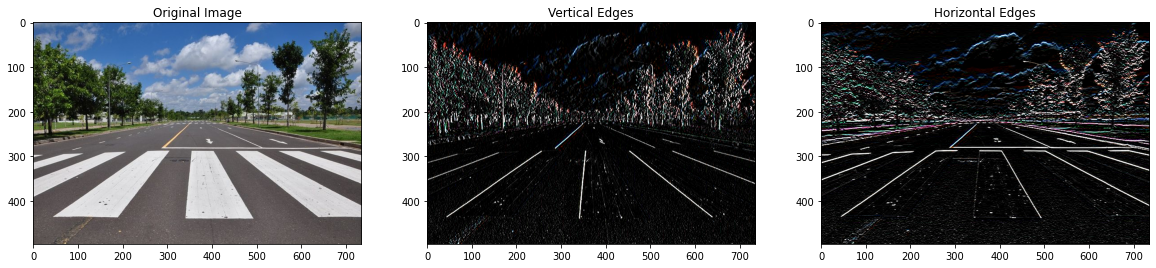

In [6]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(img[:,:,::-1])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(vertical_edges)
plt.title('Vertical Edges')

plt.subplot(1,3,3)
plt.imshow(horizontal_edges)
plt.title('Horizontal Edges')

#### Question: for any given problem, what should the convolutional filters look like? 

# Pooling Layers

A pooling layer provides a way to reduce the size of the feature maps which in turn makes computation faster and reduces the number of learnable parameters. The most popular technique is $\textit{max pooling}$ which summarizes each non-overlapping nxn block of pixels in an image using the maximum value in the block.

In [7]:
def max_pool(img):
    channels = []
    for channel in range(3):
        result = skimage.measure.block_reduce(img[:,:,channel], (2,2), np.max)
        channels.append(result)
    pooled_image = np.stack(channels)
    pooled_image = pooled_image.transpose(1,2,0)
    return pooled_image

pooled_image = max_pool(img)
pooled_image_x2 = max_pool(pooled_image)

Text(0.5, 1.0, 'Max Pooling x2')

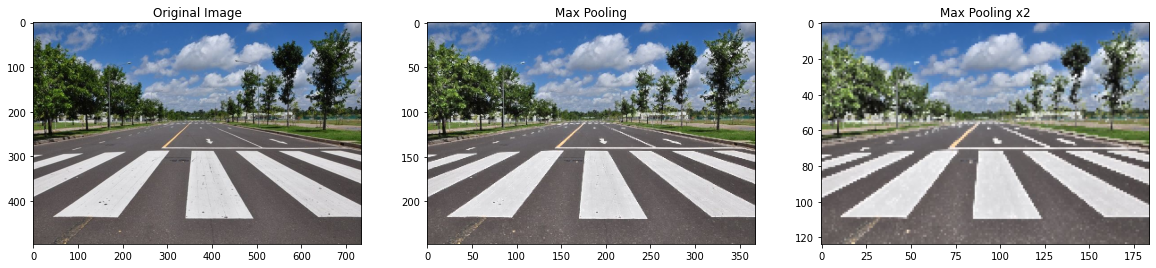

In [8]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(img[:,:,::-1])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(pooled_image[:,:,::-1])
plt.title('Max Pooling')

plt.subplot(1,3,3)
plt.imshow(pooled_image_x2[:,:,::-1])
plt.title('Max Pooling x2')

# Exercise

In [9]:
from IPython.display import Image
  
Image(url="images/tiger.png", width=600, height=300)

## Exercise: Experiment with your own filters and view its effect on the image

In [10]:
# horizontal edges filter

img = cv2.imread('/mnt/cnn_session/images/tiger.png')

kernel_1 = np.array([[ , , ], 
                    [, , ], 
                    [ , , ]])
img_kernel_1 = cv2.filter2D(img, -1, kernel_1)

kernel_2 = np.array([[ , , ], 
                    [ , , ], 
                    [ , , ]])
img_kernel_2 = cv2.filter2D(img, -1,  kernel_2)

SyntaxError: invalid syntax (<ipython-input-10-82691adf5286>, line 5)

In [ ]:
plt.figure(figsize=(20,20))

plt.subplot(1,3,1)
plt.imshow(img[:,:,::-1])
plt.title('Original Image')

plt.subplot(1, 3, 2)
plt.imshow(img_kernel_1)
plt.title('First Filter')

plt.subplot(1,3,3)
plt.imshow(img_kernel_2)
plt.title('Second Filter')

# CNN Architecture

In [13]:
from IPython.display import Image
  
Image(url="./images/CNN_architecture.png", width=600, height=500)

In [14]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, kernel_size = 5, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, kernel_size = 5, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(16)
        self.fc = nn.Linear(400, 120)
        self.fc1 = nn.Linear(120, num_classes)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = nn.ReLU()(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = self.conv2(x)
        x = self.bn2(x)
        x = nn.ReLU()(x)
        x = F.max_pool2d(x, 2, 2)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.ReLU()(x)
        
        x = self.fc1(x)
        x = F.softmax(x, dim=1)
        return x

In [15]:
image_path = "./"
IMAGE_SIZE = 32
transform = transforms.Compose(
    [transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)), transforms.ToTensor()]
)
mnist_train_dataset = torchvision.datasets.MNIST(
    root=image_path, train=True, transform=transform, download=True
)
mnist_test_dataset = torchvision.datasets.MNIST(
    root=image_path, train=False, transform=transform, download=True
)
batch_size = 32
torch.manual_seed(1)
train_dl = DataLoader(mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(mnist_test_dataset, batch_size, shuffle=False)

100%|██████████| 9912422/9912422 [00:01<00:00, 7559829.14it/s] 


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


  0%|          | 0/28881 [00:00<?, ?it/s]

100%|██████████| 28881/28881 [00:00<00:00, 354288.06it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 6905774.44it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 192760.59it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [ ]:
def train_model(
    CNN, trainloader, testloader, epochs, learning_rate, num_classes
):
    torch.manual_seed(39)
    model = CNN(num_classes)
    print(model)

    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(
        model.parameters(), lr=learning_rate, weight_decay=1e-4
    )

    acc_hist_train = []
    acc_hist_val = []
    for epoch in range(1, epochs + 1):
        # Train
        model.train()  # set to train mode
        accuracy_hist_train = 0
        for x_batch, y_batch in tqdm(trainloader):
            pred = model(x_batch)
            loss = criterion(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            is_correct = (torch.argmax(pred, dim=1) == y_batch).sum().float()
            accuracy_hist_train += is_correct.mean()

        accuracy_hist_train /= len(train_dl.dataset)

        acc_hist_train.append(accuracy_hist_train)

        accuracy_hist_valid = 0
        model.eval()
        with torch.no_grad():
            for x, y in testloader:
                pred = model(x) #predict 
                is_correct = (torch.argmax(pred, dim=1) == y).sum().float()
                accuracy_hist_valid += is_correct.mean()
            accuracy_hist_valid /= len(testloader.dataset)
            acc_hist_val.append(accuracy_hist_valid)

        print(f"Epoch: {epoch}")
        print(f"Training Accuracy: {accuracy_hist_train}")
        print(f"Test Accuracy: {accuracy_hist_valid}")
        print("---------------------------------------------")

    return model, acc_hist_train, acc_hist_val

In [ ]:
model, acc_hist_train, acc_hist = train_model(
    CNN, train_dl, valid_dl, 3, 0.0001, 10
)

In [ ]:
for i, (x, y) in enumerate(valid_dl):
    pred = model(x)
    print(f"prediction: {torch.argmax(pred,dim=1).numpy()}")
    print(f"Real:       {y.numpy()}")
    correct = torch.argmax(pred, dim=1) == y
    print(
        "Percentage Correct: % {:.3f}".format(100 * correct.sum().numpy() / 32)
    )
    print("-----------------------------")
    if i == 3:
        break

In [ ]:
image, label = next(iter(valid_dl)) # sample images, labels from dataset
preds = torch.argmax(model(image), dim=1) # get predictions for images

In [ ]:
# here we plot the image, its prediction, and its true label to investigate our model performance
plt.figure(figsize=(10,10))
j = 0
for img, lbl, predicted in zip(image[:12,:,:,:], label[:12], preds[:12]):
    img = img.numpy()
    lbl = lbl.numpy()
    img = np.transpose(img, (1,2,0))
    plt.subplot(4, 3, j+1)
    plt.imshow(img, cmap='gray')
    plt.tight_layout()
    plt.title(f'prediction: {predicted}')
    j += 1